# Project for CS545

Sam Armstrong, Saloni Choudhary, Brandon Hua

In [ ]:
import pandas as pd
import datetime
# univariate stacked lstm example
# from numpy import array
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import l1, l2, l1_l2

## Get Data


In [ ]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [3]:
tickers = 'mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  29 of 29 downloaded


,Adj Close AAPL,Adj Close AXP,Adj Close BA,Adj Close CAT,Adj Close CSCO,Adj Close CVX,Adj Close DIS,Adj Close GE,Adj Close GS,Adj Close HD,...,Volume NKE,Volume PFE,Volume PG,Volume TRV,Volume UNH,Volume UTX,Volume V,Volume VZ,Volume WMT,Volume XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data.drop([datetime.datetime(2016, 1, 18)])
# data = data.drop([datetime.datetime(2014, 12, 3)])
# data = data.drop([datetime.datetime(2019, 12, 4)])
data.shape

(1259, 174)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [5]:
MMM = data[['Close MMM', 'High MMM', 'Low MMM', 'Open MMM', 'Volume MMM']]
MMM.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

AAPL = data[['Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
AAPL.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
AXP = data[['Adj Close AXP', 'Close AXP', 'High AXP', 'Low AXP', 'Open AXP', 'Volume AXP']]
AXP.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
BA = data[['Adj Close BA', 'Close BA', 'High BA', 'Low BA', 'Open BA', 'Volume BA']]
BA.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CAT = data[['Adj Close CAT', 'Close CAT', 'High CAT', 'Low CAT', 'Open CAT', 'Volume CAT']]
CAT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CVX = data[['Adj Close CVX', 'Close CVX', 'High CVX', 'Low CVX', 'Open CVX', 'Volume CVX']]
CVX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CSCO = data[['Adj Close CSCO', 'Close CSCO', 'High CSCO', 'Low CSCO', 'Open CSCO', 'Volume CSCO']]
CSCO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
KO = data[['Adj Close KO', 'Close KO', 'High KO', 'Low KO', 'Open KO', 'Volume KO']]
KO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
DIS = data[['Adj Close DIS', 'Close DIS', 'High DIS', 'Low DIS', 'Open DIS', 'Volume DIS']]
DIS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
XOM = data[['Adj Close XOM', 'Close XOM', 'High XOM', 'Low XOM', 'Open XOM', 'Volume XOM']]
XOM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GE = data[['Adj Close GE', 'Close GE', 'High GE', 'Low GE', 'Open GE', 'Volume GE']]
GE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GS = data[['Adj Close GS', 'Close GS', 'High GS', 'Low GS', 'Open GS', 'Volume GS']]
GS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
HD = data[['Adj Close HD', 'Close HD', 'High HD', 'Low HD', 'Open HD', 'Volume HD']]
HD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
IBM = data[['Adj Close IBM', 'Close IBM', 'High AAPL', 'Low IBM', 'Open IBM', 'Volume IBM']]
IBM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
INTC = data[['Adj Close INTC', 'Close INTC', 'High INTC', 'Low INTC', 'Open INTC', 'Volume INTC']]
INTC.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JNJ = data[['Adj Close JNJ', 'Close JNJ', 'High JNJ', 'Low JNJ', 'Open JNJ', 'Volume JNJ']]
JNJ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JPM = data[['Adj Close JPM', 'Close JPM', 'High JPM', 'Low JPM', 'Open JPM', 'Volume JPM']]
JPM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MCD = data[['Adj Close MCD', 'Close MCD', 'High MCD', 'Low MCD', 'Open MCD', 'Volume MCD']]
MCD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MRK = data[['Adj Close MRK', 'Close MRK', 'High MRK', 'Low MRK', 'Open MRK', 'Volume MRK']]
MRK.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MSFT = data[['Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]
MSFT.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
NKE = data[['Adj Close NKE', 'Close NKE', 'High NKE', 'Low NKE', 'Open NKE', 'Volume NKE']]
NKE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PFE = data[['Adj Close PFE', 'Close PFE', 'High PFE', 'Low PFE', 'Open PFE', 'Volume PFE']]
PFE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PG = data[['Adj Close PG', 'Close PG', 'High PG', 'Low PG', 'Open PG', 'Volume PG']]
PG.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
TRV = data[['Adj Close TRV', 'Close TRV', 'High TRV', 'Low TRV', 'Open TRV', 'Volume TRV']]
TRV.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UTX = data[['Adj Close UTX', 'Close UTX', 'High UTX', 'Low UTX', 'Open UTX', 'Volume UTX']]
UTX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UNH = data[['Adj Close UNH', 'Close UNH', 'High UNH', 'Low UNH', 'Open UNH', 'Volume UNH']]
UNH.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
VZ = data[['Adj Close VZ', 'Close VZ', 'High VZ', 'Low VZ', 'Open VZ', 'Volume VZ']]
VZ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
V = data[['Adj Close V', 'Close V', 'High V', 'Low V', 'Open V', 'Volume V']]
V.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
WMT = data[['Adj Close WMT', 'Close WMT', 'High WMT', 'Low WMT', 'Open WMT', 'Volume WMT']]
WMT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

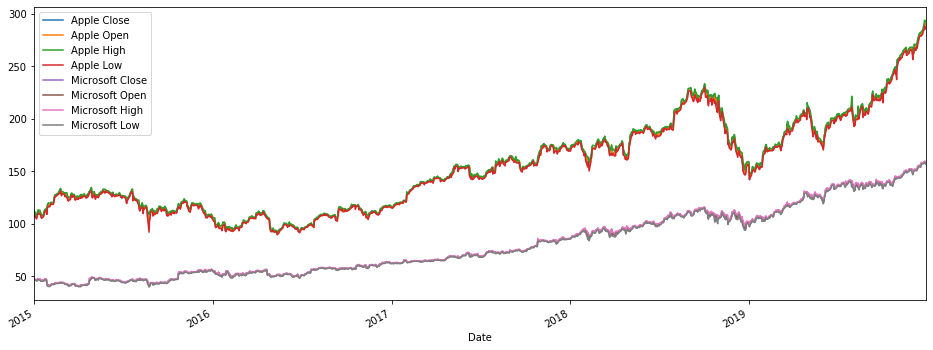

In [6]:
AAPL['Close'].plot(figsize=(16,6))
AAPL['Open'].plot(figsize=(16,6))
AAPL['High'].plot(figsize=(16,6))
AAPL['Low'].plot(figsize=(16,6))
MSFT['Close'].plot(figsize=(16,6))
MSFT['Open'].plot(figsize=(16,6))
MSFT['High'].plot(figsize=(16,6))
graph1 = MSFT['Low'].plot(figsize=(16,6))
graph1.legend(['Apple Close', 'Apple Open', 'Apple High', 'Apple Low', 'Microsoft Close', 'Microsoft Open', 'Microsoft High', 'Microsoft Low'])

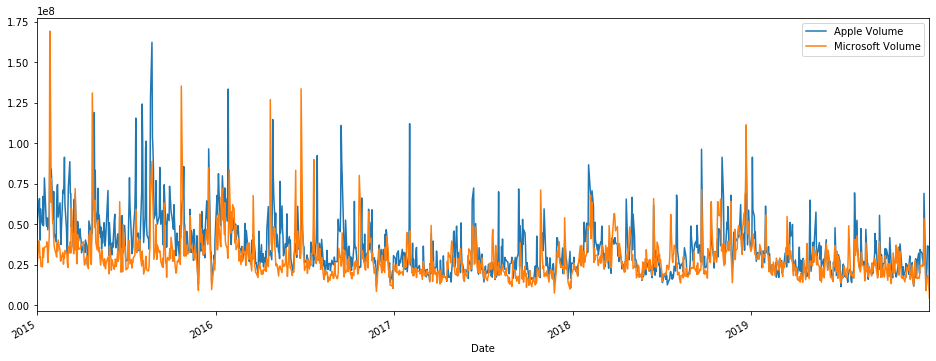

In [7]:
AAPL['Volume'].plot(figsize=(16,6))
MSFT['Volume'].plot(figsize=(16,6)).legend(['Apple Volume', 'Microsoft Volume'])

## Linear Model

Train on 1003 samples
Epoch 1/30
1003/1003 [==============================] - 0s 468us/sample - loss: 0.1170
Epoch 2/30
1003/1003 [==============================] - 0s 24us/sample - loss: 0.1060
Epoch 3/30
1003/1003 [==============================] - 0s 25us/sample - loss: 0.0981
Epoch 4/30
1003/1003 [==============================] - 0s 24us/sample - loss: 0.0924
Epoch 5/30
1003/1003 [==============================] - 0s 28us/sample - loss: 0.0878
Epoch 6/30
1003/1003 [==============================] - 0s 28us/sample - loss: 0.0840
Epoch 7/30
1003/1003 [==============================] - 0s 25us/sample - loss: 0.0805
Epoch 8/30
1003/1003 [==============================] - 0s 23us/sample - loss: 0.0775
Epoch 9/30
1003/1003 [==============================] - 0s 25us/sample - loss: 0.0745
Epoch 10/30
1003/1003 [==============================] - 0s 25us/sample - loss: 0.0718
Epoch 11/30
1003/1003 [==============================] - 0s 27us/sample - loss: 0.0693
Epoch 12/30
1003/1003 [======

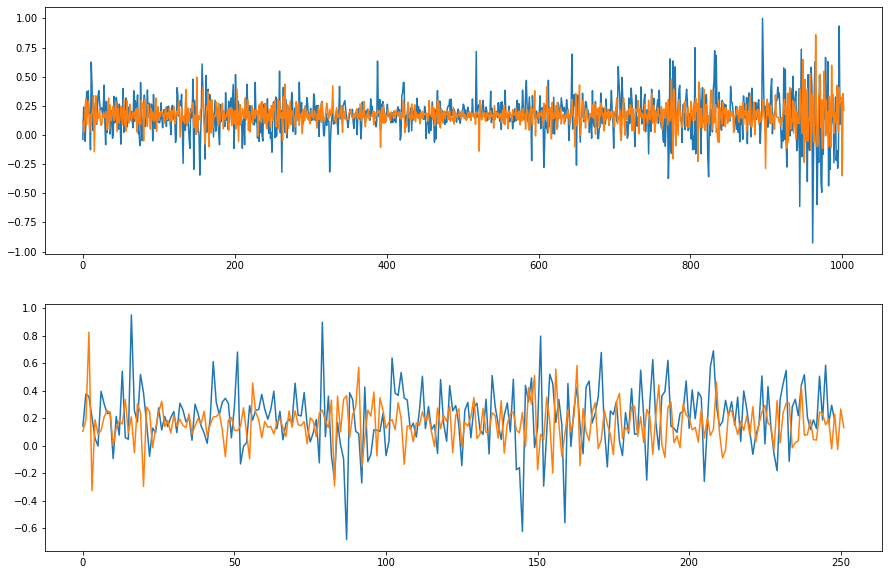

In [8]:
look_back = 3
univariate_seq_1 = AAPL['Close'].diff()[1:].values.reshape(-1, 1)
data_std = np.hstack((AAPL['Volume'].values[1:].reshape(-1, 1), univariate_seq_1))
sc = MinMaxScaler(feature_range = (-1, 1))
univariate_seq = sc.fit_transform(data_std)

train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
testing_set = univariate_seq[n_train - look_back:]

X_test = []
y_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, 1])
    y_test.append(testing_set[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, 1])
    y_train.append(training_set[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)

regressor = Sequential()
regressor.add(Dense(units=1, activation="linear"))


regressor.compile(optimizer = 'adam', loss = 'mse')
regressor.fit(X_train, y_train, epochs = 30)

predicted_train = regressor.predict(X_train)
predicted_test = regressor.predict(X_test)

predicted_train_ustd = sc.inverse_transform(np.repeat(predicted_train.reshape(-1, 1), 2, axis=1))[:, 1]
y_train_ustd = sc.inverse_transform(np.repeat(y_train.reshape(-1, 1), 2, axis=1))[:, 1]
predicted_test_ustd = sc.inverse_transform(np.repeat(predicted_test.reshape(-1, 1), 2, axis=1))[:, 1]
y_test_ustd = sc.inverse_transform(np.repeat(y_test.reshape(-1, 1), 2, axis=1))[:, 1]

plt.figure(figsize=(15, 10))
plt.title("Linear Model")
plt.subplot(2, 1, 1)
plt.plot(y_train[look_back:])
plt.plot(predicted_train)

plt.subplot(2, 1, 2)
plt.plot(y_test[look_back:])
plt.plot(predicted_test)

rmse = np.average(np.sqrt(np.square(y_test_ustd - predicted_test_ustd)))
print("RMSE: $" + str(rmse))

RMSE: $2.7961916682954953


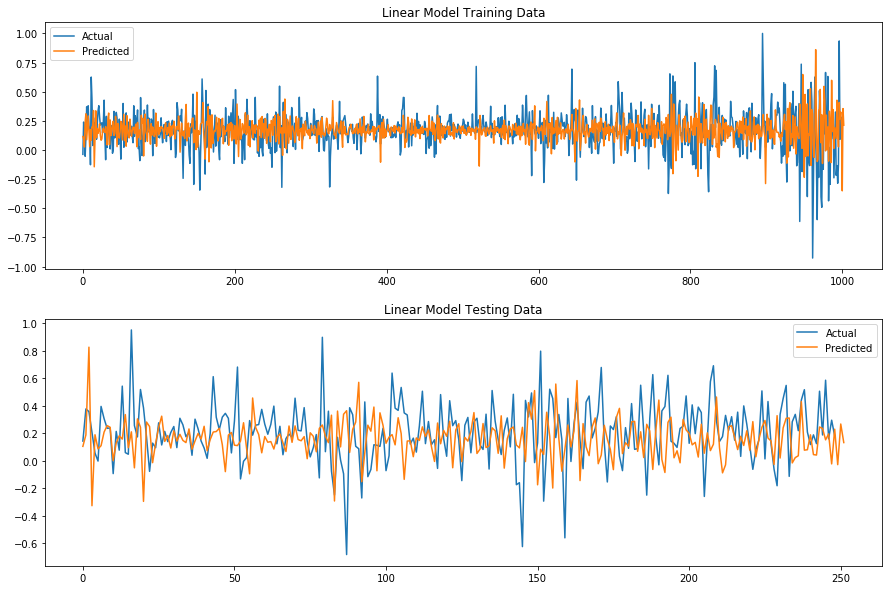

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Linear Model Training Data")
plt.plot(y_train[look_back:])
plt.plot(predicted_train)
plt.legend(["Actual", "Predicted"])
plt.subplot(2, 1, 2)
plt.title("Linear Model Testing Data")
plt.plot(y_test[look_back:])
plt.plot(predicted_test)
plt.legend(["Actual", "Predicted"])
rmse = np.average(np.sqrt(np.square(y_test_ustd - predicted_test_ustd)))
print("RMSE: $" + str(rmse))

## Univariate Model

Train on 1003 samples
Epoch 1/30
1003/1003 [==============================] - 4s 4ms/sample - loss: 0.1865
Epoch 2/30
1003/1003 [==============================] - 1s 783us/sample - loss: 0.0118
Epoch 3/30
1003/1003 [==============================] - 1s 746us/sample - loss: 0.0077
Epoch 4/30
1003/1003 [==============================] - 1s 703us/sample - loss: 0.0075
Epoch 5/30
1003/1003 [==============================] - 1s 725us/sample - loss: 0.0075
Epoch 6/30
1003/1003 [==============================] - 1s 669us/sample - loss: 0.0076
Epoch 7/30
1003/1003 [==============================] - 1s 648us/sample - loss: 0.0075
Epoch 8/30
1003/1003 [==============================] - 1s 741us/sample - loss: 0.0075
Epoch 9/30
1003/1003 [==============================] - 1s 757us/sample - loss: 0.0074
Epoch 10/30
1003/1003 [==============================] - 1s 774us/sample - loss: 0.0075
Epoch 11/30
1003/1003 [==============================] - 1s 711us/sample - loss: 0.0075
Epoch 12/30
1003/1003

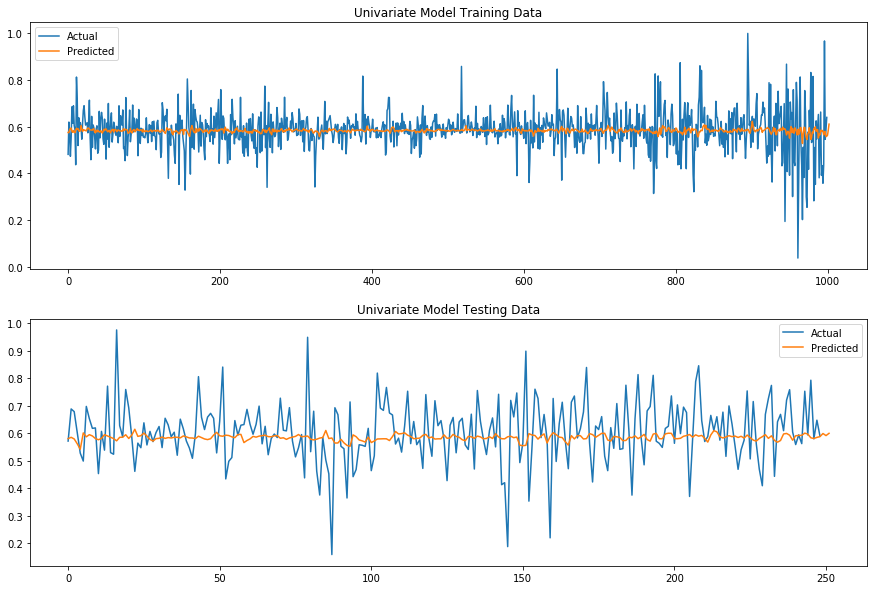

In [10]:
look_back = 3
univariate_seq_1 = AAPL['Close'].diff()[1:].values.reshape(-1, 1)
data_std = np.hstack((AAPL['Volume'].values[1:].reshape(-1, 1), univariate_seq_1))
sc = MinMaxScaler(feature_range = (0, 1))
univariate_seq = sc.fit_transform(data_std)

train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
testing_set = univariate_seq[n_train - look_back:]

X_test = []
y_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, 1])
    y_test.append(testing_set[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, 1])
    y_train.append(training_set[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units=30, activation="elu", return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(30, activation="elu",return_sequences=True))
regressor.add(LSTM(30, activation="elu"))
regressor.add(Dense(units=1))


regressor.compile(optimizer = 'adam', loss = 'mse')
regressor.fit(X_train, y_train, epochs = 30)

predicted_train = regressor.predict(X_train)
predicted_test = regressor.predict(X_test)

predicted_train_ustd = sc.inverse_transform(np.repeat(predicted_train.reshape(-1, 1), 2, axis=1))[:, 1]
y_train_ustd = sc.inverse_transform(np.repeat(y_train.reshape(-1, 1), 2, axis=1))[:, 1]
predicted_test_ustd = sc.inverse_transform(np.repeat(predicted_test.reshape(-1, 1), 2, axis=1))[:, 1]
y_test_ustd = sc.inverse_transform(np.repeat(y_test.reshape(-1, 1), 2, axis=1))[:, 1]

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Univariate Model Training Data")
plt.plot(y_train[look_back:])
plt.plot(predicted_train)
plt.legend(["Actual", "Predicted"])
plt.subplot(2, 1, 2)
plt.title("Univariate Model Testing Data")
plt.plot(y_test[look_back:])
plt.plot(predicted_test)
plt.legend(["Actual", "Predicted"])
rmse = np.average(np.sqrt(np.square(y_test_ustd - predicted_test_ustd)))
print("RMSE: $" + str(rmse))

## Univariate Model with Regularization

Train on 976 samples
Epoch 1/30
976/976 [==============================] - 9s 10ms/sample - loss: 1.5413
Epoch 2/30
976/976 [==============================] - 5s 6ms/sample - loss: 1.0616
Epoch 3/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.7321
Epoch 4/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.4915
Epoch 5/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.3225
Epoch 6/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.2109
Epoch 7/30
976/976 [==============================] - 4s 4ms/sample - loss: 0.1432
Epoch 8/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.1071
Epoch 9/30
976/976 [==============================] - 5s 5ms/sample - loss: 0.0834
Epoch 10/30
976/976 [==============================] - 5s 6ms/sample - loss: 0.0665
Epoch 11/30
976/976 [==============================] - 4s 4ms/sample - loss: 0.0546
Epoch 12/30
976/976 [==============================] - 5s 5ms/s

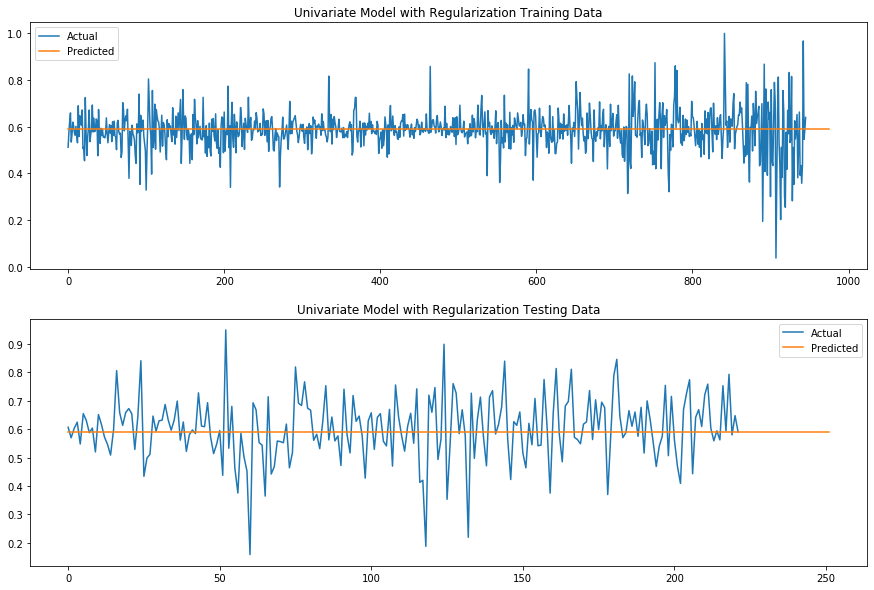

In [11]:
look_back = 30
univariate_seq_1 = AAPL['Close'].diff()[1:].values.reshape(-1, 1)
data_std = np.hstack((AAPL['Volume'].values[1:].reshape(-1, 1), univariate_seq_1))
sc = MinMaxScaler(feature_range = (0, 1))
univariate_seq = sc.fit_transform(data_std)

train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
testing_set = univariate_seq[n_train - look_back:]

X_test = []
y_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, 1])
    y_test.append(testing_set[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, 1])
    y_train.append(training_set[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))

regressor = Sequential()
regressor.add(LSTM(units=30, activation="elu", dropout=0.01, recurrent_regularizer=l1_l2(l1= 0.001, l2 = .001),kernel_regularizer=l1_l2(l1 =0.001, l2 =0.001 ), return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(30, activation="elu", dropout=0.01, recurrent_regularizer=l1_l2(l1= 0.001, l2 = .001),kernel_regularizer=l1_l2(l1 =0.001, l2 =0.001 ),return_sequences=True))
regressor.add(LSTM(30, activation="elu", dropout=0.01, recurrent_regularizer=l1_l2(l1= 0.001, l2 = .001),kernel_regularizer=l1_l2(l1 =0.001, l2 =0.001 )))
regressor.add(Dense(units=1))


regressor.compile(optimizer = 'adam', loss = 'mse')
regressor.fit(X_train, y_train, epochs = 30)

predicted_train = regressor.predict(X_train)
predicted_test = regressor.predict(X_test)

predicted_train_ustd = sc.inverse_transform(np.repeat(predicted_train.reshape(-1, 1), 2, axis=1))[:, 1]
y_train_ustd = sc.inverse_transform(np.repeat(y_train.reshape(-1, 1), 2, axis=1))[:, 1]
predicted_test_ustd = sc.inverse_transform(np.repeat(predicted_test.reshape(-1, 1), 2, axis=1))[:, 1]
y_test_ustd = sc.inverse_transform(np.repeat(y_test.reshape(-1, 1), 2, axis=1))[:, 1]

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Univariate Model with Regularization Training Data")
plt.plot(y_train[look_back:])
plt.plot(predicted_train)
plt.legend(["Actual", "Predicted"])
plt.subplot(2, 1, 2)
plt.title("Univariate Model with Regularization Testing Data")
plt.plot(y_test[look_back:])
plt.plot(predicted_test)
plt.legend(["Actual", "Predicted"])
rmse = np.average(np.sqrt(np.square(y_test_ustd - predicted_test_ustd)))
print("RMSE: $" + str(rmse))

## Univariate Model With GRU

In [12]:
look_back = 1
univariate_seq = AAPL['Close']
train_percent = .8
n_train = int(train_percent * len(univariate_seq))
training_set = univariate_seq[:n_train]
training_set=pd.DataFrame(training_set)
testing_set = univariate_seq[n_train - look_back:]
testing_set=pd.DataFrame(testing_set)
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(look_back, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Initialising the RNN
regressor = Sequential()

# # Adding the first LSTM layer and some Dropout regularisation
regressor.add(GRU(units=3000, return_sequences=True, input_shape=(X_train.shape[1],1)))

regressor.add(LSTM(units = 3000, dropout=0.01, recurrent_dropout=0.01))
regressor.add(Dense(units = 3000))
regressor.add(Dropout(0.01))
regressor.add(Dense(units = 3000))
regressor.add(Dense(units = 3000))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adagrad', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10)

testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))
X_test = []
for i in range(look_back, testing_set_scaled.shape[0]):
    X_test.append(testing_set_scaled[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price)

Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 36s 36ms/sample - loss: 3.3803
Epoch 2/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 3.6122e-04
Epoch 3/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 2.6520e-04
Epoch 4/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 2.6438e-04
Epoch 5/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 2.8089e-04
Epoch 6/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 2.7481e-04
Epoch 7/10
1006/1006 [==============================] - 32s 31ms/sample - loss: 2.7434e-04
Epoch 8/10
1006/1006 [==============================] - 32s 32ms/sample - loss: 2.6447e-04
Epoch 9/10
1006/1006 [==============================] - 32s 31ms/sample - loss: 2.7395e-04
Epoch 10/10
1006/1006 [==============================] - 32s 31ms/sample - loss: 2.7797e-04


In [13]:
predicted_stock_price_1 = regressor.predict(X_train)
predicted_stock_price_1 = sc.inverse_transform(predicted_stock_price_1)
predicted_stock_price_1 = pd.DataFrame(predicted_stock_price_1)

RMSE: $2.3567947872101302


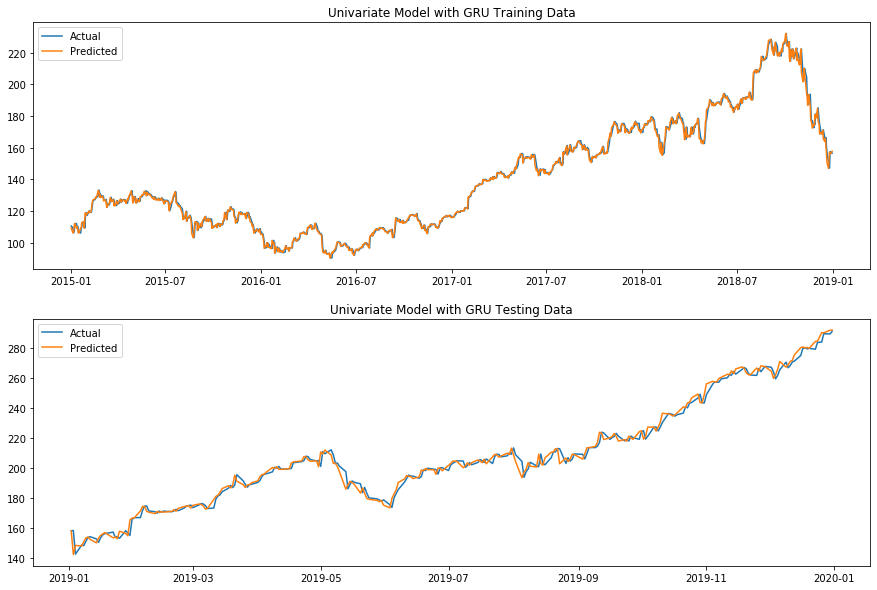

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Univariate Model with GRU Training Data")
predicted_stock_price_1.index = training_set[look_back:].index
plt.plot(predicted_stock_price_1)
plt.plot(training_set[look_back:])
plt.legend(["Actual", "Predicted"])
plt.subplot(2, 1, 2)
plt.title("Univariate Model with GRU Testing Data")
predicted_stock_price.index = testing_set[look_back:].index
plt.plot(predicted_stock_price)
plt.plot(testing_set[look_back:])
plt.legend(["Actual", "Predicted"])
rmse = np.average(np.sqrt(np.square(testing_set[look_back:].to_numpy() - predicted_stock_price.to_numpy())))
print("RMSE: $" + str(rmse))

RMSE: $2.3567947872101302


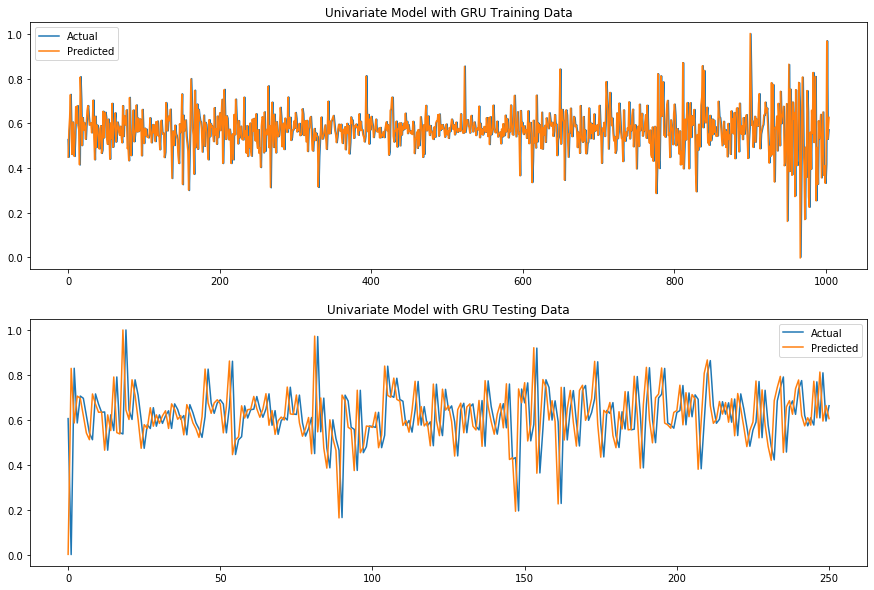

In [15]:
new = MinMaxScaler(feature_range = (0, 1))

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Univariate Model with GRU Training Data")
predicted_stock_price_1.index = training_set[look_back:].index
plt.plot(new.fit_transform(predicted_stock_price_1.diff()[1:]))
plt.plot(new.transform(training_set[look_back:].diff()[1:]))
plt.legend(["Actual", "Predicted"])
plt.subplot(2, 1, 2)
plt.title("Univariate Model with GRU Testing Data")
predicted_stock_price.index = testing_set[look_back:].index
plt.plot(new.fit_transform(predicted_stock_price.diff()[1:]))
plt.plot(new.transform(testing_set[look_back:].diff()[1:]))
plt.legend(["Actual", "Predicted"])
rmse = np.average(np.sqrt(np.square(testing_set[look_back:].to_numpy() - predicted_stock_price.to_numpy())))
print("RMSE: $" + str(rmse))

## Get Data


In [16]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [17]:
tickers = 'aapl msft'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  2 of 2 downloaded


,Adj Close AAPL,Adj Close MSFT,Close AAPL,Close MSFT,High AAPL,High MSFT,Low AAPL,Low MSFT,Open AAPL,Open MSFT,Volume AAPL,Volume MSFT
Date,,,,,,,,,,,,


In [18]:
#data = data.drop([datetime.datetime(2016, 1, 18)])
data.shape

(1259, 12)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [19]:
AAPL = data[['Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
MSFT = data[['Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]

## Setting Up the Data

In [21]:
def setup(look_back, data):
    train_percent = .8
    n_train = int(train_percent * len(data))
    train = data[:n_train]
    test = data[n_train - look_back:]
    return train, test

def partition_data(train_scaled, test_scaled, look_back):
    X_train = []
    y_train = []
    X_test = []
    for i in range(look_back, train_scaled.shape[0]):
        X_train.append(train_scaled[i-look_back:i, :])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    for i in range(look_back, test_scaled.shape[0]):
        X_test.append(test_scaled[i-look_back:i, :])
    X_test = np.array(X_test)

    return X_train, y_train, X_test

def plot(predicted, y, predicted_1, y_1, title):
    new = MinMaxScaler(feature_range = (0, 1))

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(new.fit_transform(y_1))
    plt.plot(new.transform(predicted_1))
    plt.legend(['Actual', 'Predicted'])
    plt.title(title + " Training Data")
    
    plt.subplot(2, 1, 2)
    plt.plot(new.fit_transform(y))
    plt.plot(new.transform(predicted))
    plt.legend(['Actual', 'Predicted'])
    plt.title(title + " Testing Data")
    rse = np.sqrt((predicted - y)**2)
    
    rmse = np.mean(rse)
    print('RMSE: %.4f' % rmse)

## Multivariate Model

In [22]:
look_back = 1

train_percent = .8
n_train = int(train_percent * len(AAPL))

train, test = setup(look_back, AAPL)
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.transform(test.to_numpy())

Y_test = test['Close AAPL'][look_back:].to_numpy().reshape(-1,1)
Y_train = train['Close AAPL'][look_back:].to_numpy().reshape(-1,1)
X_train, y_train, X_test, = partition_data(train_scaled, test_scaled, look_back)

In [23]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
# regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

In [24]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 30)

Train on 1006 samples
Epoch 1/30
1006/1006 [==============================] - 6s 6ms/sample - loss: 0.1312
Epoch 2/30
1006/1006 [==============================] - 0s 320us/sample - loss: 0.0243
Epoch 3/30
1006/1006 [==============================] - 0s 264us/sample - loss: 0.0063
Epoch 4/30
1006/1006 [==============================] - 0s 330us/sample - loss: 0.0018
Epoch 5/30
1006/1006 [==============================] - 0s 329us/sample - loss: 0.0014
Epoch 6/30
1006/1006 [==============================] - 0s 386us/sample - loss: 0.0012
Epoch 7/30
1006/1006 [==============================] - 0s 332us/sample - loss: 9.1363e-04
Epoch 8/30
1006/1006 [==============================] - 0s 367us/sample - loss: 7.0509e-04
Epoch 9/30
1006/1006 [==============================] - 0s 415us/sample - loss: 5.7941e-04
Epoch 10/30
1006/1006 [==============================] - 0s 348us/sample - loss: 4.9165e-04
Epoch 11/30
1006/1006 [==============================] - 0s 391us/sample - loss: 4.3000e-04
E

RMSE: 3.1452


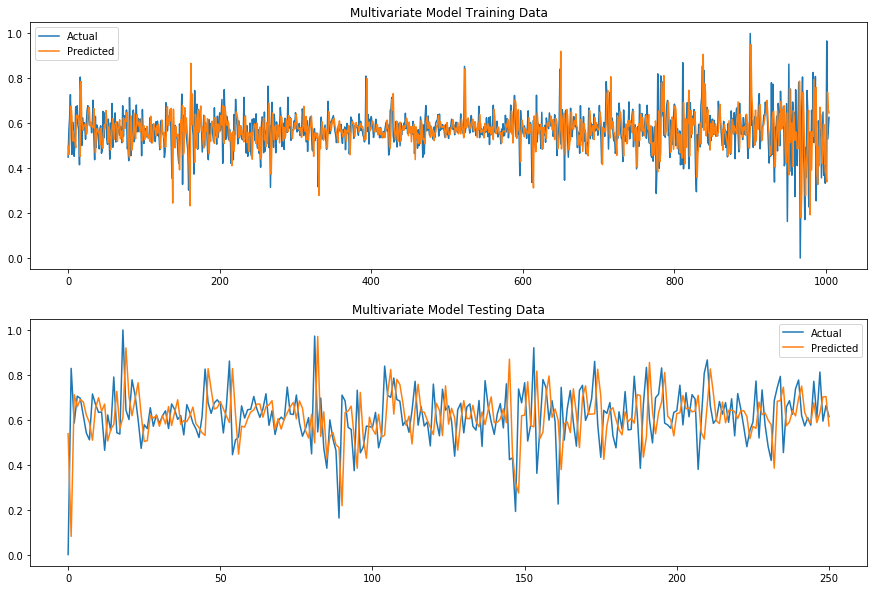

In [25]:
predicted_stock_price = regressor.predict(X_train)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, X_train.shape[2], axis=1))[:, 0]
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_train = pd.DataFrame(Y_train)

predicted_stock_price_1 = regressor.predict(X_test)
predicted_stock_price_1 = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price_1, X_train.shape[2], axis=1))[:, 0]
predicted_stock_price_1 = pd.DataFrame(predicted_stock_price_1)
Y_test = pd.DataFrame(Y_test)

title = 'Multivariate Model'
plot(predicted_stock_price_1.diff()[1:], Y_test.diff()[1:], predicted_stock_price.diff()[1:], Y_train.diff()[1:], title)

## Multivariate Model with regularizers (L2)

In [26]:
look_back = 1
train, test = setup(look_back, AAPL)

scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.fit_transform(test)
X_train, y_train, X_test = partition_data(train_scaled, test_scaled, look_back)
print(X_train.shape, X_train.shape)

(1006, 1, 5) (1006, 1, 5)


In [27]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], X_train.shape[2]), 
                   kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1), bias_regularizer=l2(0.01)))

# Adding the output layer
regressor.add(Dense(units = 1))


In [28]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10)

Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 2s 2ms/sample - loss: 3.1485
Epoch 2/10
1006/1006 [==============================] - 0s 95us/sample - loss: 2.0036
Epoch 3/10
1006/1006 [==============================] - 0s 122us/sample - loss: 1.3094
Epoch 4/10
1006/1006 [==============================] - 0s 128us/sample - loss: 0.8856
Epoch 5/10
1006/1006 [==============================] - 0s 135us/sample - loss: 0.6223
Epoch 6/10
1006/1006 [==============================] - 0s 118us/sample - loss: 0.4563
Epoch 7/10
1006/1006 [==============================] - 0s 101us/sample - loss: 0.3499
Epoch 8/10
1006/1006 [==============================] - 0s 103us/sample - loss: 0.2801
Epoch 9/10
1006/1006 [==============================] - 0s 109us/sample - loss: 0.2333
Epoch 10/10
1006/1006 [==============================] - 0s 121us/sample - loss: 0.2010


RMSE: 2.5972


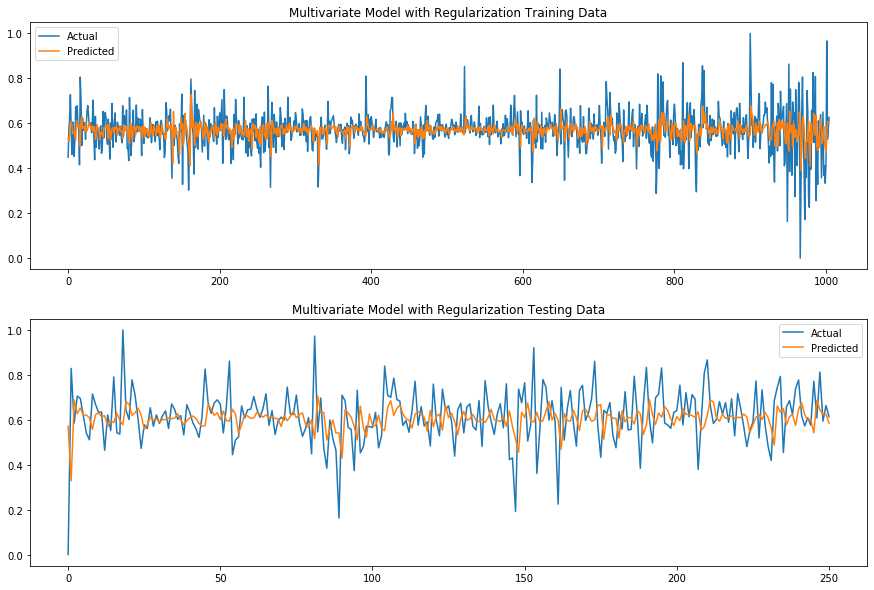

In [29]:
predicted_stock_price = regressor.predict(X_train)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
Y_train = pd.DataFrame(y_train)

predicted_stock_price_1 = regressor.predict(X_test)
predicted_stock_price_1 = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price_1, X_train.shape[2], axis=1))[:, 0]
predicted_stock_price_1 = pd.DataFrame(predicted_stock_price_1)
Y_test = pd.DataFrame(Y_test)

title = 'Multivariate Model with Regularization'
plot(predicted_stock_price_1.diff()[1:], Y_test.diff()[1:], predicted_stock_price.diff()[1:], Y_train.diff()[1:], title)

## Multivariate GRU

In [30]:
look_back = 1

scSeries = MinMaxScaler(feature_range = (0, 1))
scSeries2 = MinMaxScaler(feature_range = (0, 1))

multi_series_data = pd.concat([AAPL, MSFT], axis=1)

print(multi_series_data.shape)
multivariate_seqs = scSeries.fit_transform(multi_series_data)
multivariate_sols = scSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))


train_percent = .8
n_train = int(train_percent * len(multivariate_seqs))
training_set = multivariate_seqs[:n_train]
Y_train = multivariate_sols[look_back:n_train]
testing_set = multivariate_seqs[n_train - look_back:]
Y_test = multivariate_sols[n_train:]

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, :])
X_train = np.array(X_train)

X_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, :])
X_test = np.array(X_test)

(1259, 10)


In [31]:
regressor = Sequential()
regressor.add(GRU(units=40,
              return_sequences=True,
              input_shape=(X_train.shape[1],10)))
regressor.add(Dropout(0.1))
regressor.add(GRU(units=40))
regressor.add(Dropout(0.1))
regressor.add(Dense(1))
regressor.compile(loss='mse', optimizer='adam')

# Fitting the RNN to the Training set
regressor.fit(X_train, Y_train, epochs = 10)

Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 4s 4ms/sample - loss: 0.0173
Epoch 2/10
1006/1006 [==============================] - 0s 267us/sample - loss: 0.0026
Epoch 3/10
1006/1006 [==============================] - 0s 368us/sample - loss: 0.0019
Epoch 4/10
1006/1006 [==============================] - 0s 272us/sample - loss: 0.0015
Epoch 5/10
1006/1006 [==============================] - 0s 212us/sample - loss: 0.0013
Epoch 6/10
1006/1006 [==============================] - 0s 233us/sample - loss: 0.0011
Epoch 7/10
1006/1006 [==============================] - 0s 217us/sample - loss: 0.0010
Epoch 8/10
1006/1006 [==============================] - 0s 310us/sample - loss: 9.6941e-04
Epoch 9/10
1006/1006 [==============================] - 0s 425us/sample - loss: 9.6412e-04
Epoch 10/10
1006/1006 [==============================] - 0s 291us/sample - loss: 9.3530e-04


RMSE: 3.1717


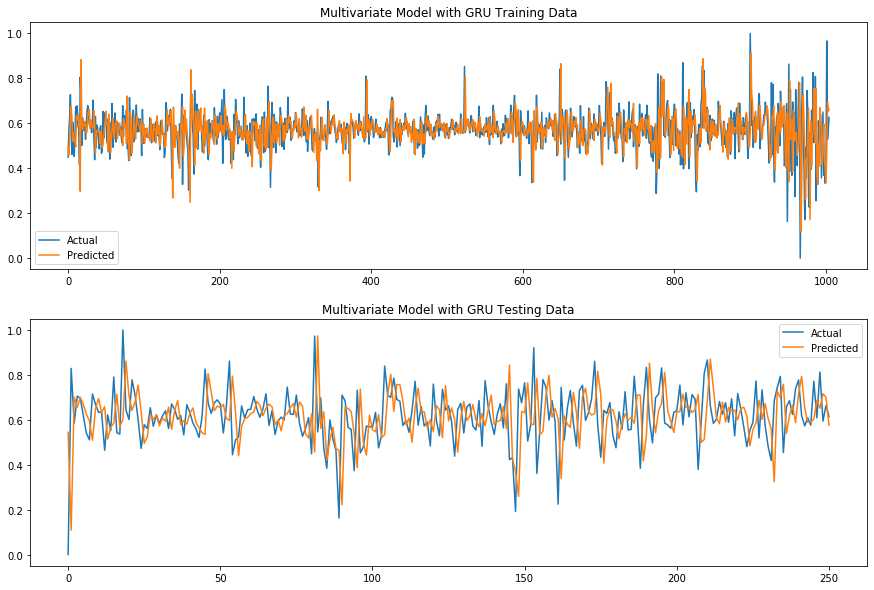

In [32]:
predicted_stock_price = regressor.predict(X_train)
predicted_stock_price_1 = regressor.predict(X_test)
Y_test1 = pd.DataFrame(scSeries2.inverse_transform(Y_test))
Y_train1 = pd.DataFrame(scSeries2.inverse_transform(Y_train))
predicted_stock_price_1 = pd.DataFrame(scSeries2.inverse_transform(predicted_stock_price_1))
predicted_stock_price = pd.DataFrame(scSeries2.inverse_transform(predicted_stock_price))
title = 'Multivariate Model with GRU'
plot(predicted_stock_price_1.diff()[1:], Y_test1.diff()[1:], predicted_stock_price.diff()[1:], Y_train1.diff()[1:], title)